In [1]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
import scipy.io as sio
import pickle

room_label = [(0, 'LivingRoom', 1, "PublicArea"),
            (1, 'MasterRoom', 0, "Bedroom"),
            (2, 'Kitchen', 1, "FunctionArea"),
            (3, 'Bathroom', 0, "FunctionArea"),
            (4, 'DiningRoom', 1, "FunctionArea"),
            (5, 'ChildRoom', 0, "Bedroom"),
            (6, 'StudyRoom', 0, "Bedroom"),
            (7, 'SecondRoom', 0, "Bedroom"),
            (8, 'GuestRoom', 0, "Bedroom"),
            (9, 'Balcony', 1, "PublicArea"),
            (10, 'Entrance', 1, "PublicArea"),
            (11, 'Storage', 0, "PublicArea"),
            (12, 'Wall-in', 0, "PublicArea"),
            (13, 'External', 0, "External"),
            (14, 'ExteriorWall', 0, "ExteriorWall"),
            (15, 'FrontDoor', 0, "FrontDoor"),
            (16, 'InteriorWall', 0, "InteriorWall"),
            (17, 'InteriorDoor', 0, "InteriorDoor")]
    
def savemat(file_path,data):
    sio.savemat(file_path,data)

def loadmat(file_path):
    return sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)

def savepkl(file_path,data):
    pickle.dump(data,open(file_path,'wb'))

def loadpkl(file_path):
    return pickle.load(open(file_path,'rb'))

def get_color_map():
    color = np.array([
        [244,242,229], # living room
        [253,244,171], # bedroom
        [234,216,214], # kitchen
        [205,233,252], # bathroom
        [208,216,135], # balcony
        [185,231,168], # balcony
        [249,222,189], # Storage
        [ 79, 79, 79], # exterior wall
        [255,225, 25], # FrontDoor
        [128,128,128], # interior wall
        [255,255,255]
    ],dtype=np.int64)
    cIdx  = np.array([1,2,3,4,1,2,2,2,2,5,1,6,1,10,7,8,9,10])-1
    return color[cIdx]

def collide2d(bbox1, bbox2, th=0):
    return not(
        (bbox1[0]-th > bbox2[2]) or
        (bbox1[2]+th < bbox2[0]) or
        (bbox1[1]-th > bbox2[3]) or
        (bbox1[3]+th < bbox2[1])
    )

edge_type = ['left-above',
    'left-below',
    'left-of',
    'above',
    'inside',
    'surrounding',
    'below',
    'right-of',
    'right-above',
    'right-below']

def point_box_relation(u,vbox):
    uy,ux = u
    vy0, vx0, vy1, vx1 = vbox
    if (ux<vx0 and uy<=vy0) or (ux==vx0 and uy==vy0):
        relation = 0 # 'left-above'
    elif (vx0<=ux<vx1 and uy<=vy0):
        relation = 3 # 'above'
    elif (vx1<=ux and uy<vy0) or (ux==vx1 and uy==vy0):
        relation = 8 # 'right-above'
    elif (vx1<=ux and vy0<=uy<vy1):
        relation = 7 # 'right-of'
    elif (vx1<ux and vy1<=uy) or (ux==vx1 and uy==vy1):
        relation = 9 # 'right-below'
    elif (vx0<ux<=vx1 and vy1<=uy):
        relation = 6 # 'below'
    elif (ux<=vx0 and vy1<uy) or (ux==vx0 and uy==vy1):
        relation = 1 # 'left-below'
    elif(ux<=vx0 and vy0<uy<=vy1):
        relation = 2 # 'left-of'
    elif(vx0<ux<vx1 and vy0<uy<vy1):
        relation = 4 # 'inside'

    return relation

def get_edges(boxes,th=9):
    edges = []
    for u in range(len(boxes)):
        for v in range(u+1,len(boxes)):
            if not collide2d(boxes[u,:4],boxes[v,:4],th=th): continue
            uy0, ux0, uy1, ux1 = boxes[u,:4].astype(int)
            vy0, vx0, vy1, vx1 = boxes[v,:4].astype(int)
            uc = (uy0+uy1)/2,(ux0+ux1)/2
            vc = (vy0+vy1)/2,(vx0+vx1)/2
            if ux0 < vx0 and ux1 > vx1 and uy0 < vy0 and uy1 > vy1:
                relation = 5 #'surrounding'
            elif ux0 >= vx0 and ux1 <= vx1 and uy0 >= vy0 and uy1 <= vy1:
                relation = 4 #'inside'
            else:
                relation = point_box_relation(uc,boxes[v,:4])
            edges.append([u,v,relation])
            
    edges = np.array(edges,dtype=int)
    return edges

door_pos = [
    'nan',
    'bottom',
    'bottom-right','right-bottom',
    'right',
    'right-top','top-right',
    'top',
    'top-left','left-top',
    'left',
    'left-bottom','bottom-left'
]

def door_room_relation(d_center,r_box):
    y0,x0,y1,x1 = r_box
    yc,xc = (y1+y0)/2, (x0+x1)/2
    y,x = d_center
    
    if x==xc and y<yc:return 7
    elif x==xc and y>yc:return 1
    elif y==yc and x<xc:return 10
    elif y==yc and x>xc:return 4
    elif x0<x<xc:
        if y<yc:return 8
        else:return 12
    elif xc<x<x1:
        if y<yc:return 6
        else:return 2
    elif y0<y<yc:
        if x<xc:return 9
        else:return 5
    elif yc<y<y1:
        if x<xc:return 11
        else:return 3
    else:return 0

In [3]:
from skimage import io
from skimage import morphology,feature,transform,measure
from pathlib import Path
from scipy import stats
from scipy import ndimage
from shapely import geometry
import numpy as np

#from .utils import collide2d,point_box_relation,door_room_relation

class Floorplan():

    @property
    def boundary(self): return self.image[...,0]
    
    @property
    def category(self): return self.image[...,1]

    @property
    def instance(self): return self.image[...,2]
    
    @property
    def inside(self): return self.image[...,3]
    
    def __init__(self,file_path):
        self.path = file_path
        self.name = Path(self.path).stem
        self.image = io.imread(self.path)
        self.h,self.w,self.c = self.image.shape
        
        self.front_door = None
        self.exterior_boundary = None
        self.rooms = None
        self.edges = None

        self.archs = None
        self.graph = None

        self._get_front_door()
        self._get_exterior_boundary()
        self._get_rooms()
        self._get_edges()
        self.frontdoor = self.image[...,0].copy()
        self.frontdoor[np.where(self.frontdoor==127)] = 0
        
    def __repr__(self): 
        return f'{self.name},({self.h},{self.w},{self.c})'

    def _get_front_door(self):
        front_door_mask = self.boundary==255
        # fast bbox
        # min_h,max_h = np.where(np.any(front_door_mask,axis=1))[0][[0,-1]]
        # min_w,max_w = np.where(np.any(front_door_mask,axis=0))[0][[0,-1]]  
        # self.front_door = np.array([min_h,min_w,max_h,max_w],dtype=int)
        region = measure.regionprops(front_door_mask.astype(int))[0]
        self.front_door = np.array(region.bbox,dtype=int)
        self.front_door_mask = front_door_mask

    def _get_exterior_boundary(self):
        if self.front_door is None: self._get_front_door()
        self.exterior_boundary = []

        min_h,max_h = np.where(np.any(self.boundary,axis=1))[0][[0,-1]]
        min_w,max_w = np.where(np.any(self.boundary,axis=0))[0][[0,-1]]
        min_h = max(min_h-10,0)
        min_w = max(min_w-10,0)
        max_h = min(max_h+10,self.h)
        max_w = min(max_w+10,self.w)

        # src: http://staff.ustc.edu.cn/~fuxm/projects/DeepLayout/index.html
        # search direction:0(right)/1(down)/2(left)/3(up)
        # find the left-top point
        flag = False
        for h in range(min_h, max_h):
            for w in range(min_w, max_w):
                if self.inside[h, w] == 255:
                    self.exterior_boundary.append((h, w, 0))
                    flag = True
                    break
            if flag:
                break
        
        # left/top edge: inside
        # right/bottom edge: outside
        while(flag):
            if self.exterior_boundary[-1][2] == 0:
                for w in range(self.exterior_boundary[-1][1]+1, max_w):
                    corner_sum = 0
                    if self.inside[self.exterior_boundary[-1][0], w] == 255:
                        corner_sum += 1
                    if self.inside[self.exterior_boundary[-1][0]-1, w] == 255:
                        corner_sum += 1
                    if self.inside[self.exterior_boundary[-1][0], w-1] == 255:
                        corner_sum += 1
                    if self.inside[self.exterior_boundary[-1][0]-1, w-1] == 255:
                        corner_sum += 1
                    if corner_sum == 1:
                        new_point = (self.exterior_boundary[-1][0], w, 1)
                        break
                    if corner_sum == 3:
                        new_point = (self.exterior_boundary[-1][0], w, 3)
                        break
            
            if self.exterior_boundary[-1][2] == 1:      
                for h in range(self.exterior_boundary[-1][0]+1, max_h): 
                    corner_sum = 0                
                    if self.inside[h, self.exterior_boundary[-1][1]] == 255:
                        corner_sum += 1
                    if self.inside[h-1, self.exterior_boundary[-1][1]] == 255:
                        corner_sum += 1
                    if self.inside[h, self.exterior_boundary[-1][1]-1] == 255:
                        corner_sum += 1
                    if self.inside[h-1, self.exterior_boundary[-1][1]-1] == 255:
                        corner_sum += 1
                    if corner_sum == 1:
                        new_point = (h, self.exterior_boundary[-1][1], 2)
                        break
                    if corner_sum == 3:
                        new_point = (h, self.exterior_boundary[-1][1], 0)
                        break

            if self.exterior_boundary[-1][2] == 2:   
                for w in range(self.exterior_boundary[-1][1]-1, min_w, -1):
                    corner_sum = 0                     
                    if self.inside[self.exterior_boundary[-1][0], w] == 255:
                        corner_sum += 1
                    if self.inside[self.exterior_boundary[-1][0]-1, w] == 255:
                        corner_sum += 1
                    if self.inside[self.exterior_boundary[-1][0], w-1] == 255:
                        corner_sum += 1
                    if self.inside[self.exterior_boundary[-1][0]-1, w-1] == 255:
                        corner_sum += 1
                    if corner_sum == 1:
                        new_point = (self.exterior_boundary[-1][0], w, 3)
                        break
                    if corner_sum == 3:
                        new_point = (self.exterior_boundary[-1][0], w, 1)
                        break

            if self.exterior_boundary[-1][2] == 3:       
                for h in range(self.exterior_boundary[-1][0]-1, min_h, -1):
                    corner_sum = 0                
                    if self.inside[h, self.exterior_boundary[-1][1]] == 255:
                        corner_sum += 1
                    if self.inside[h-1, self.exterior_boundary[-1][1]] == 255:
                        corner_sum += 1
                    if self.inside[h, self.exterior_boundary[-1][1]-1] == 255:
                        corner_sum += 1
                    if self.inside[h-1, self.exterior_boundary[-1][1]-1] == 255:
                        corner_sum += 1
                    if corner_sum == 1:
                        new_point = (h, self.exterior_boundary[-1][1], 0)
                        break
                    if corner_sum == 3:
                        new_point = (h, self.exterior_boundary[-1][1], 2)
                        break

            if new_point != self.exterior_boundary[0]:
                self.exterior_boundary.append(new_point)
            else:
                flag = False
        self.exterior_boundary = [[r,c,d,0] for r,c,d in self.exterior_boundary]
        
        door_y1,door_x1,door_y2,door_x2 = self.front_door
        door_h,door_w = door_y2-door_y1,door_x2-door_x1
        is_vertical = door_h>door_w or door_h==1 # 

        insert_index = None
        door_index = None
        new_p = []
        th = 3
        for i in range(len(self.exterior_boundary)):
            y1,x1,d,_ = self.exterior_boundary[i]
            y2,x2,_,_ = self.exterior_boundary[(i+1)%len(self.exterior_boundary)] 
            if is_vertical!=d%2: continue
            if is_vertical and (x1-th<door_x1<x1+th or x1-th<door_x2<x1+th): # 1:down 3:up
                l1 = geometry.LineString([[y1,x1],[y2,x2]])    
                l2 = geometry.LineString([[door_y1,x1],[door_y2,x1]])  
                l12 = l1.intersection(l2)
                if l12.length>0:
                    dy1,dy2 = l12.xy[0] # (y1>y2)==(dy1>dy2)
                    insert_index = i
                    door_index = i+(y1!=dy1)
                    if y1!=dy1: new_p.append([dy1,x1,d,1])
                    if y2!=dy2: new_p.append([dy2,x1,d,1])
            elif not is_vertical and (y1-th<door_y1<y1+th or y1-th<door_y2<y1+th):
                l1 = geometry.LineString([[y1,x1],[y2,x2]])    
                l2 = geometry.LineString([[y1,door_x1],[y1,door_x2]])  
                l12 = l1.intersection(l2)
                if l12.length>0:
                    dx1,dx2 = l12.xy[1] # (x1>x2)==(dx1>dx2)
                    insert_index = i
                    door_index = i+(x1!=dx1)
                    if x1!=dx1: new_p.append([y1,dx1,d,1])
                    if x2!=dx2: new_p.append([y1,dx2,d,1])                

        if len(new_p)>0:
            self.exterior_boundary = self.exterior_boundary[:insert_index+1]+new_p+self.exterior_boundary[insert_index+1:]
        self.exterior_boundary = self.exterior_boundary[door_index:]+self.exterior_boundary[:door_index]

        self.exterior_boundary = np.array(self.exterior_boundary,dtype=int)

    def _get_rooms(self):
        rooms = []
        regions = measure.regionprops(self.instance)
        for region in regions:
            c = stats.mode(self.category[region.coords[:,0],region.coords[:,1]])[0][0]
            y0,x0,y1,x1 = np.array(region.bbox) 
            rooms.append([y0,x0,y1,x1,c])
        self.rooms = np.array(rooms,dtype=int)

    def _get_edges(self,th=9):
        if self.rooms is None: self._get_rooms()
        edges = []
        for u in range(len(self.rooms)):
            for v in range(u+1,len(self.rooms)):
                if not collide2d(self.rooms[u,:4],self.rooms[v,:4],th=th): continue
                uy0, ux0, uy1, ux1, c1 = self.rooms[u]
                vy0, vx0, vy1, vx1, c2 = self.rooms[v]
                uc = (uy0+uy1)/2,(ux0+ux1)/2
                vc = (vy0+vy1)/2,(vx0+vx1)/2
                if ux0 < vx0 and ux1 > vx1 and uy0 < vy0 and uy1 > vy1:
                    relation = 5 #'surrounding'
                elif ux0 >= vx0 and ux1 <= vx1 and uy0 >= vy0 and uy1 <= vy1:
                    relation = 4 #'inside'
                else:
                    relation = point_box_relation(uc,self.rooms[v,:4])
                edges.append([u,v,relation])
                
        self.edges = np.array(edges,dtype=int)

    def _get_archs(self):
        '''
        Interior doors
        '''
        archs = []
        
        # treat archs as instances
        # index = len(self.rooms)+1

        # for category in range(num_category,len(room_label)):
        for category in [17]: # only get doors for building graphs
            mask = (self.category==category).astype(np.uint8)

            # distance transform -> threshold -> corner detection -> remove corner -> watershed -> label region
            #distance = cv2.distanceTransform(mask,cv2.DIST_C,3)
            distance = ndimage.morphology.distance_transform_cdt(mask)

            # local_maxi = feature.peak_local_max(distance, indices=False) # line with one pixel
            local_maxi = (distance>1).astype(np.uint8) 

            # corner_measurement = feature.corner_shi_tomasi(local_maxi) # short lines will be removed
            corner_measurement = feature.corner_harris(local_maxi) 

            local_maxi[corner_measurement>0] = 0

            markers = measure.label(local_maxi)

            labels = morphology.watershed(-distance, markers, mask=mask, connectivity=8)
            regions = measure.regionprops(labels)

            for region in regions:
                y0,x0,y1,x1 = np.array(region.bbox) 
                archs.append([y0,x0,y1,x1,category])

        self.archs = np.array(archs,dtype=int)

    def _get_graph(self,th=9):
        '''
        More detail graph
        '''
        if self.rooms is None: self._get_rooms()
        if self.archs is None: self._get_archs()
        graph = []
        door_pos = [[None,0] for i in range(len(self.rooms))]
        edge_set = set()

        # add accessible edges
        doors = self.archs[self.archs[:,-1]==17]
        for i in range(len(doors)):
            bbox = doors[i,:4]
            
            # left <-> right
            for row in range(bbox[0],bbox[2]):

                u = self.instance[row,bbox[1]-1]-1
                v = self.instance[row,bbox[3]+1]-1
                if (u,v) in edge_set or (v,u) in edge_set:continue
                if u>=0 and v>=0 and (u,v):
                    edge_set.add((u,v))
                    graph.append([u,v,None,1,i])

            # up <-> down
            for col in range(bbox[1],bbox[3]):
                u = self.instance[bbox[0]-1,col]-1
                v = self.instance[bbox[2]+1,col]-1
                if (u,v) in edge_set or (v,u) in edge_set:continue
                if u>=0 and v>=0 and (u,v):
                    edge_set.add((u,v))
                    graph.append([u,v,None,1,i])

        # add adjacent edges
        for u in range(len(self.rooms)):
            for v in range(u+1,len(self.rooms)):
                if (u,v) in edge_set or (v,u) in edge_set: continue

                # collision detection
                if collide2d(self.rooms[u,:4],self.rooms[v,:4],th=th):
                    edge_set.add((u,v))
                    graph.append([u,v,None,0,None])

        # add edge relation
        for i in range(len(graph)):
            u,v,e,t,d = graph[i]
            uy0, ux0, uy1, ux1 = self.rooms[u,:4]
            vy0, vx0, vy1, vx1 = self.rooms[v,:4]
            uc = (uy0+uy1)/2,(ux0+ux1)/2
            vc = (vy0+vy1)/2,(vx0+vx1)/2

            if ux0 < vx0 and ux1 > vx1 and uy0 < vy0 and uy1 > vy1:
                relation = 5 #'surrounding'
            elif ux0 >= vx0 and ux1 <= vx1 and uy0 >= vy0 and uy1 <= vy1:
                relation = 4 #'inside'
            else:
                relation = point_box_relation(uc,self.rooms[v,:4])
            
            graph[i][2] = relation


            if d is not None:
                c_u = self.rooms[u,-1]
                c_v = self.rooms[v,-1]

                if c_u > c_v and door_pos[u][0] is None:
                    room = u
                else:
                    room = v
                door_pos[room][0]=d
                

                d_center = self.archs[d,:4]
                d_center = (d_center[:2]+d_center[2:])/2.0

                dpos =  door_room_relation(d_center,self.rooms[room,:4])
                if dpos!=0: door_pos[room][1] = dpos
        
        self.graph = graph
        self.door_pos = door_pos

    def to_dict(self,xyxy=True,dtype=int):
        '''
        Compress data, notice:
        !!! int->uint8: a(uint8)+b(uint8) may overflow !!!
        '''
        return {
            'name'      :self.name,
            'types'     :self.rooms[:,-1].astype(dtype),
            'boxes'     :(self.rooms[:,[1,0,3,2]]).astype(dtype) 
            if xyxy else self.rooms[:,:4].astype(dtype),
            'boundary'  :self.exterior_boundary[:,[1,0,2,3]].astype(dtype)
            if xyxy else self.exterior_boundary.astype(dtype),
            'edges'     :self.edges.astype(dtype)
        }

if __name__ == "__main__":
    pass

In [4]:
Layer_Rank = [0,4,3,11,12,1,7,5,6,8,2,10,9]
Names_Lib = ['Living','Entrance','Bathroom','Storage','wall_in','Master room','Second room','Child room','Study room','Guest room','Kitchen','Dining room','Balcony']#
Names_sim_Lib = ['Living','Bathroom','Storage/closet','Bed room','Kitchen','Dining','Balcony']
#sum(data['edges'][:,:2].tolist(),[])

In [6]:
def map_type(ori_type):
    del_list = []
    for i,j in enumerate(ori_type):
        if j in Layer_Rank: 
            if  j == 0:
                continue
            elif j == Layer_Rank[1]:
                del_list.append(i)
            elif j == Layer_Rank[2]:
                ori_type[i] = 2
            elif j in Layer_Rank[3:5]:
                ori_type[i] = 3
            elif j in Layer_Rank[5:10]:
                ori_type[i] = 4
            elif j == Layer_Rank[10]:
                ori_type[i] = 5
            elif j == Layer_Rank[11]:
                ori_type[i] = 6
            elif j == Layer_Rank[12]:
                ori_type[i] = 7  
        else:
            del_list.append(i)
    
    return ori_type,del_list

def re_order(type_list,room_list,ada_list):
    all_type = np.zeros(8)
    all_room = np.zeros((8,4))
    all_graph = np.zeros((8,8))
    pair = np.zeros((36,2))
    boundfeature = np.zeros((36,2))
    ind_living = np.where(np.array(type_list) == 0)[0][0]
    all_type[0] = 1
    all_room[0] = room_list[ind_living]
    ind = 1
    mapped_type,del_ind = map_type(type_list)
    if ind_living != 0:
        ada_list[np.where(ada_list == ind_living)] = 10
        ada_list[np.where(ada_list < ind_living)] += 1
        ada_list[np.where(ada_list == 10)] = 0
        for f in del_ind:
            ada_list[np.where(ada_list == f)] = 0
    for m,n in enumerate(ada_list):
        count = int(m*2)
        all_graph[n[0]][n[1]] = 1
        all_graph[n[1]][n[0]] = 1
        pair[count] = n
        pair[count+1] = np.array([n[1],n[0]])
        if 0 in n:
            boundfeature[count][0] = 1
            boundfeature[count+1][0] = 1
        else:
            boundfeature[count][1] = 1
            boundfeature[count+1][1] = 1
    for k in range(len(mapped_type)-len(del_ind)):
        all_graph[k][k] = 1
    for i,j in enumerate(mapped_type):
        if i == ind_living or i in del_ind:
            continue
        else:
            all_type[ind] = j
            all_room[ind] = room_list[i]
            ind += 1
    return all_type,all_room,all_graph,pair,boundfeature

def get_loc(x,y,size):
    x_min = x - size
    x_max = x + size + 1
    y_min = y - size
    y_max = y + size + 1
    return x_min,x_max,y_min,y_max

In [ ]:
for i in range(10):

    os.makedirs("img_loc_sqe/%d" % (i), exist_ok=True)
    os.makedirs("img_room_sqe/%d" % (i), exist_ok=True)
    os.makedirs("img_area_sqe/%d" % (i), exist_ok=True)

os.makedirs("img_room_vq", exist_ok=True)
os.makedirs("img_loc_vq", exist_ok=True)
os.makedirs("img_area_vq", exist_ok=True)
os.makedirs("img_boundary", exist_ok=True)

4 channel 3 geometry + 1 site

In [ ]:
import cv2
count = 0
value = 255

for g in range(80788):
    file_path = 'your_downloaded_path/%d.png' % (g)
    fp = Floorplan(file_path)
    data = fp.to_dict()
    Types = data['types'].tolist()
    Rooms = np.array(data['boxes'])
    OriginalGraph = np.array(data['edges'][:,:2].tolist())
    t,r,graph,pair,boundfeature = re_order(Types,Rooms,OriginalGraph)

    img_data = np.zeros((128, 128, 4),dtype=np.int32) 
    area_data = np.zeros((128, 128),dtype=np.int32)
    boundary_data = np.zeros((128, 128, 3),dtype=np.int32)
    mask = np.zeros((128, 128),dtype=np.int32)
    site = np.zeros((128, 128),dtype=np.int32)

    mask[(np.where(fp.inside==255)[0]/2).astype(np.int32),(np.where(fp.inside==255)[1]/2).astype(np.int32)] = value # inside mask
    site[(np.where(fp.boundary==127)[0]/2).astype(np.int32),(np.where(fp.boundary==127)[1]/2).astype(np.int32)] = int(value/2) # boundary
    site[(np.where(fp.boundary==255)[0]/2).astype(np.int32),(np.where(fp.boundary==255)[1]/2).astype(np.int32)] = int(value/2) # boundary
    Door_x = np.mean((np.where(fp.frontdoor==255)[0]/2)).astype(np.int32)
    Door_y = np.mean((np.where(fp.frontdoor==255)[1]/2)).astype(np.int32)
    Dx1,Dx2,Dy1,Dy2 = get_loc(Door_x,Door_y,5)
    site[Dx1:Dx2,Dy1:Dy2] = value # front door

    boundary_data[Dx1:Dx2,Dy1:Dy2,2] = value
    boundary_data[(np.where(fp.inside==255)[0]/2).astype(np.int32),(np.where(fp.inside==255)[1]/2).astype(np.int32),1] = value
    boundary_data[(np.where(site==int(value/2))[0]).astype(np.int32),(np.where(site==int(value/2))[1]).astype(np.int32),0] = value

    region =(r/2).astype(np.int32)
    room_data = np.zeros((128, 128, 3),dtype=np.int32)
    loc_data = np.zeros((128, 128, 3),dtype=np.int32)
    area_region = np.zeros((128, 128),dtype=np.int32)

    img_data[:,:,:-1] = value
    img_data[:,:,-1] = mask
    area_data = np.ones((128, 128),dtype=np.int32)*value
    
    cv2.imwrite("img_loc_sqe/0/%d.png" % (g), img_data)
    cv2.imwrite("img_room_sqe/0/%d.png" % (g), img_data)
    cv2.imwrite("img_area_sqe/0/%d.png" % (g), area_data)
    cv2.imwrite("img_loc_vq/%d.png" % (count), img_data)
    cv2.imwrite("img_room_vq/%d.png" % (count), img_data)
    cv2.imwrite("img_area_vq/%d.png" % (count), area_data)
    cv2.imwrite("img_boundary/%d.jpg" % (count), boundary_data)

    count += 1

    img_data[:,:,:-1] = room_data
    img_data[:,:,-1] = site
    area_data = room_data
    final = 0

    for i in range(9):
        
        if i < 8 and t[i]!=0:

            #channel = channels[int(t[i])]
            
            if region[i][1]!=region[i][3] and region[i][0]!=region[i][2]:

                x = ((region[i][1]+region[i][3])/2).astype(np.int32)
                y = ((region[i][0]+region[i][2])/2).astype(np.int32)

                x1,x2,y1,y2 = get_loc(x,y,5)
                loc_data[x1:x2,y1:y2,:] = value

                room_data[region[i][1]:region[i][3],region[i][0]:region[i][2],:] = value
                room_data[np.where(mask==0)[0],np.where(mask==0)[1],:] = 0

                img_data[:,:,:-1] = room_data
                cv2.imwrite("img_room_sqe/%d/%d.png" % (i+1,g), img_data)
                cv2.imwrite("img_room_vq/%d.png" % (count), img_data)

                img_data[:,:,:-1] = loc_data
                cv2.imwrite("img_loc_sqe/%d/%d.png" % (i+1,g), img_data)
                cv2.imwrite("img_loc_vq/%d.png" % (count), img_data)

                area_edge = ((np.sqrt(np.unique(room_data[:,:,0], return_counts=True)[1][1])-1)/2).astype(np.int32)
                Ax1,Ax2,Ay1,Ay2 = get_loc(64,64,area_edge)
                area_region[Ax1:Ax2,Ay1:Ay2] = value
                area_data = area_region
                cv2.imwrite("img_area_sqe/%d/%d.png" % (i+1,g), area_data)
                cv2.imwrite("img_area_vq/%d.png" % (count), area_data)

            else:

                cv2.imwrite("img_room_sqe/%d/%d.png" % (i+1,g), img_data)
                cv2.imwrite("img_room_vq/%d.png" % (count), img_data)
                cv2.imwrite("img_loc_sqe/%d/%d.png" % (i+1,g), img_data)
                cv2.imwrite("img_loc_vq/%d.png" % (count), img_data)
                cv2.imwrite("img_area_sqe/%d/%d.png" % (i+1,g), area_data)
                cv2.imwrite("img_area_vq/%d.png" % (count), area_data)

            count += 1
            room_data = np.zeros((128, 128, 3),dtype=np.int32)
            loc_data = np.zeros((128, 128, 3),dtype=np.int32)
            area_region = np.zeros((128, 128),dtype=np.int32)
            img_data[:,:,:-1] = room_data
            area_data = area_region

        elif final == 0:
            
            img_data[:,:,:-1] = int(value/2)
            img_data[:,:,-1] = mask

            area_data = np.ones((128, 128),dtype=np.int32)*int(value/2)
            cv2.imwrite("img_room_sqe/%d/%d.png" % (i+1,g), img_data)
            cv2.imwrite("img_loc_sqe/%d/%d.png" % (i+1,g), img_data)
            cv2.imwrite("img_area_sqe/%d/%d.png" % (i+1,g), area_data)
            cv2.imwrite("img_room_vq/%d.png" % (count), img_data)
            cv2.imwrite("img_loc_vq/%d.png" % (count), img_data)
            cv2.imwrite("img_area_vq/%d.png" % (count), area_data)
            count += 1
            final = 1


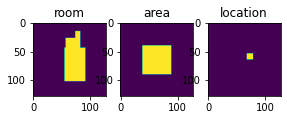

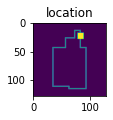

In [28]:
bb = io.imread("img_room_vq\%d.png" % (1))
plt.subplot(1, 4, 1)
plt.imshow(bb[:,:,2])
plt.title("room")
bb = io.imread("img_area_vq\%d.png" % (1))
plt.subplot(1, 4, 2)
plt.imshow(bb[:,:])
plt.title("area")
bb = io.imread("img_loc_vq\%d.png" % (1))
plt.subplot(1, 4, 3)
plt.imshow(bb[:,:,2])
plt.title("location")
plt.show()
bb = io.imread("img_loc_vq\%d.png" % (1))
plt.subplot(1, 4, 4)
plt.imshow(bb[:,:,3])
plt.title("location")
plt.show()

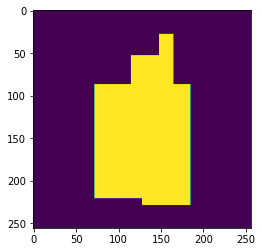

In [9]:
plt.imshow(fp.inside)

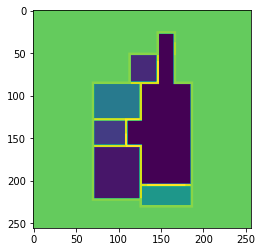

In [18]:
plt.imshow(fp.category)

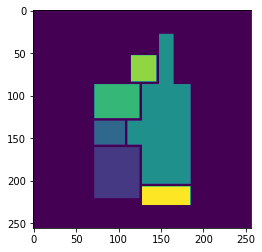

In [10]:
plt.imshow(fp.instance)